In [337]:
%reset

## 运行信息
python 3.9。13
Jupyter-notebook 6.5.2

In [19]:
# 加载所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## 仿真任务
下述函数产生随机的任务，并产生对应的评分函数

In [20]:
def initialization(parameter):
    #产生随机的工作表
    joblist = pd.DataFrame(columns=['d_min','d_max','w_o','w_f','p','w','start','stop'],
                           dtype = int)
    #Trapezoidal Suitability Function，打分函数，列标题代表区块开始的时间点
    tsf = pd.DataFrame(0,
                       index=range(parameter['time_units']),
                       columns=range(parameter['n']))
    # 依次生成每一个任务的属性
    for i in range(parameter['n']):
        #时间段：w,d_min,d_max,d
        d_min = np.random.randint(parameter['d_min'],parameter['d_max']+1)
        d_max = np.random.randint(d_min,parameter['d_max']+1)
        w = np.random.randint(d_max,parameter['w_max']+1)
        #时间点：w_o,w_f,start,stop
        w_o = np.random.randint(0,parameter['time_units']-w)
        w_f = w_o + w
        #优先级：p
        p = np.random.randint(1,parameter['p_max']+1)
        # 更新joblist
        joblist.loc[i] = (d_min,d_max,w_o,w_f,p,w,0,0)

        # 更新打分函数
        s_i = tsf[i].copy()
        # 梯形4个顶点
        a = w_o
        b = int( w_o + np.ceil((w - d_max)/2) )
        c = b + d_max
        d = w_f
        #赋值1
        s_i[range(b,c)] = 1
        #赋值2
        if b > a:
            degree_1 = 1/(2*(b-a))
            n_1 = 1
            for j in range(a,b):
                s_i[j] = degree_1 * (2 * n_1 - 1)
                n_1 += 1
        #赋值3
        if d > c:
            degree_2 = 1/(2*(d-c))
            n_2 = 1
            for j in range(d-1,c-1,-1):
                s_i[j] = degree_2 * (2 * n_2 - 1)
                n_2 += 1
        #更新打分函数
        tsf[i] = s_i

    return tsf,joblist

## PD算法
pd_sequencing 对给定的工作列表进行选择与初步定位
pd_timing 对初步定位的工作左右延伸，填满时间轴

In [21]:
def pd_sequencing(parameter,job_list,job,TSF):
    pd_job = job.copy()
    pd_jobindex = list(job_list['index_list'])
    pd_skip = list(job_list['skip'])
    pd_worst = list(job_list['worst'])
    #总时间轴,1代表位置可用
    pd_timetable = pd.Series(1,index=range(parameter['time_units']))
    #初始化总时间轴，因为有可能已经有任务指定了时间
    for i in range(parameter['n']):
        pd_timetable.loc[range(pd_job.loc[i,'start'],pd_job.loc[i,'stop'])]=0
    #任务时间轴,1代表该时间在该任务的窗口中
    empty_timetable = pd.Series(0,index=range(parameter['time_units']))
    #建立空工作表，按顺序存放被选择的工作的序号
    chosen_job_list = list()

    #对每一个工作进行判断
    for i in range(len(pd_jobindex)):

        if pd_skip[i]==0:
            continue

        job_index = pd_jobindex[i]
        job_info = pd_job.loc[job_index,]

        d_min = job_info.loc['d_min']
        d_max = job_info.loc['d_max']
        w_o = job_info.loc['w_o']
        w_f = job_info.loc['w_f']
        p = job_info.loc['p']
        w = job_info.loc['w']
        #下序列用来存放每一个开始时间，长度为d_min的工作带来的收益
        position_value = pd.Series(0,index=range(parameter['time_units']))
        #假设没有可供使用的位置
        at_least_one = False
        #对每一个位置进行测试
        for j in range(w-d_min+1):
            test_start = w_o+j
            test_stop = test_start+d_min
            test_job = empty_timetable.copy()
            test_job.loc[range(test_start,test_stop)]=1
            #判断位置是否可用
            if np.sum(test_job*pd_timetable) == d_min:
                at_least_one = True
                position_value.loc[test_start] = \
                    np.sum(TSF.loc[range(test_start,test_stop),job_index])
        #如果有至少一个可用位置，则选择最大/最小的那个
        if at_least_one:
            # 判断最大最小位置
            if pd_worst[i]==1:
                position_value_bw = position_value.max()
            else:
                position_value_bw = \
                    pd.Series(list(set(position_value))).sort_values()[1]

            decide_start = \
                np.min(position_value.index[position_value == position_value_bw])
            decide_stop = decide_start+d_min
            #更新工作表
            pd_job.loc[job_index,'start'] = decide_start
            pd_job.loc[job_index,'stop'] = decide_stop
            #更新工作序号表
            chosen_job_list.append(job_index)
        else:
            decide_start = 0
            decide_stop = 0
        #刚刚被占用的位置不再可用
        pd_timetable.loc[range(decide_start,decide_stop)]=0

    return pd_job,chosen_job_list

In [22]:
def pd_timing(pd_chosen_jobindex,pd_job):
    test_pd_job = pd_job.copy()
    #对每一个工作进行左右延伸
    for i in range(len(pd_chosen_jobindex)):
        job_index = pd_chosen_jobindex[i]
        job_info = test_pd_job.loc[job_index,]

        d_min = job_info.loc['d_min']
        d_max = job_info.loc['d_max']
        w_o = job_info.loc['w_o']
        w_f = job_info.loc['w_f']
        p = job_info.loc['p']
        w = job_info.loc['w']
        start = job_info.loc['start']
        stop = job_info.loc['stop']
        #左右边界
        new_start = np.nanmax([test_pd_job.loc[test_pd_job.loc[:,'stop']<=start,'stop'].max(),
                               w_o,stop-d_max])
        new_stop = np.nanmin([test_pd_job.loc[test_pd_job.loc[:,'start']>=stop,'start'].min(),
                              w_f,new_start+d_max])
        #左右延伸
        test_pd_job.loc[job_index,'start'] = new_start
        test_pd_job.loc[job_index,'stop'] = new_stop
    return test_pd_job

In [23]:
def get_timetable(job,parameter):
    empty_timetable = pd.Series(-1,index=range(parameter['time_units']))
    for i in range(parameter['n']):
        empty_timetable.loc[range(job.loc[i,'start'],job.loc[i,'stop'])]=i
    return empty_timetable

In [24]:
def score(JOB,TSF,parameter):
    s = 0
    for i in range(parameter['n']):
        start = JOB.loc[i,'start']
        stop = JOB.loc[i,'stop']
        p = JOB.loc[i,'p']

        s_i = 0
        for j in range(start,stop):
            s_i += TSF.loc[j,i]

        s += s_i * p
    return s

In [25]:
def pd_get_score(f_parameter, job_list, f_job, f_tsf):
    f_job_after_sequencing, f_job_index_sequencing_chosen = \
        pd_sequencing(f_parameter, job_list, f_job,f_tsf)
    f_job_after_timing = \
        pd_timing(f_job_index_sequencing_chosen, f_job_after_sequencing)
    f_score = score(f_job_after_timing, f_tsf, f_parameter)
    return f_score

## LA算法
LA算法基于PD算法，采用一步向前的展望

In [26]:
def LA(job, f_job_index, f_parameter, f_tsf):
    f_job = job.copy()

    #总时间轴,1代表位置可用
    f_timetable = pd.Series(1, index=range(f_parameter['time_units']))
    #任务时间轴,1代表该时间在该任务的窗口中
    empty_timetable = pd.Series(0, index=range(f_parameter['time_units']))

    for i in range(f_parameter['n']):
        job_index = f_job_index[i]
        job_info = f_job.loc[job_index,]

        d_min = job_info.loc['d_min']
        d_max = job_info.loc['d_max']
        w_o = job_info.loc['w_o']
        w_f = job_info.loc['w_f']
        p = job_info.loc['p']
        w = job_info.loc['w']

        test_score = 0
        best_start = 0
        best_stop = 0

        #在此处进行一步向前的展望
        for start in range(w_o,w_f-d_min+1):
            for d in range(d_min,min(d_max,w_f-start)+1):
                stop = start+d
                test_timetable = empty_timetable.copy()
                test_timetable.loc[range(start,stop)]=1

                if np.sum(test_timetable * f_timetable) == d:
                    test_LA_job = f_job.copy()
                    test_LA_job.loc[job_index,'start'] = start
                    test_LA_job.loc[job_index,'stop'] = stop
                    test_job_index_ordered_by_p = f_job_index[(i + 1):]

                    job_list = pd.DataFrame(columns=[],
                                            dtype = int)

                    job_list.insert(job_list.shape[1],'index_list',test_job_index_ordered_by_p)
                    job_list.insert(job_list.shape[1],'skip',[1]*len(test_job_index_ordered_by_p))
                    job_list.insert(job_list.shape[1],'worst',[1]*len(test_job_index_ordered_by_p))

                    new_test_score = \
                        pd_get_score(f_parameter, job_list, test_LA_job, f_tsf)

                    test_score = max(test_score,new_test_score)
                    if new_test_score == test_score:
                        best_start = start
                        best_stop = stop

        f_job.loc[job_index, 'start'] = best_start
        f_job.loc[job_index, 'stop'] = best_stop

        f_timetable.loc[range(best_start, best_stop)]=0

    return f_job

## GA算法
GA算法基于PD算法，以任务列表、是否跳过、最优最差为3个基因
PMX_crossover 为任务列表交叉互换产生子代的过程
binomial_crossover 为是否跳过、最优最差这两个0-1序列交叉互换产生子代的过程

In [27]:
def PMX_crossover(parent1, parent2):
    '''
    parent1 and parent2 are 1D np.array
    '''
    rng = np.random.default_rng()

    cutoff_1, cutoff_2 = np.sort(rng.choice(np.arange(len(parent1)+1), size=2, replace=False))

    def PMX_one_offspring(p1, p2):
        offspring = np.zeros(len(p1), dtype=p1.dtype)

        # Copy the mapping section (middle) from parent1
        offspring[cutoff_1:cutoff_2] = p1[cutoff_1:cutoff_2]

        # copy the rest from parent2 (provided it's not already there
        for i in np.concatenate([np.arange(0,cutoff_1), np.arange(cutoff_2,len(p1))]):
            candidate = p2[i]
            while candidate in p1[cutoff_1:cutoff_2]: # allows for several successive mappings
                #print(f"Candidate {candidate} not valid in position {i}") # DEBUGONLY
                candidate = p2[np.where(p1 == candidate)[0][0]]
            offspring[i] = candidate
        return offspring

    offspring1 = PMX_one_offspring(parent1, parent2)

    return offspring1


In [28]:
def binomial_crossover(parent1, parent2):
    if parent1 == 1:
        if parent2 == 1:
            son = np.random.binomial(1,0.9)
        else:
            son = np.random.binomial(1,0.5)

    if parent1 == 0:
        if parent2 == 0:
            son = np.random.binomial(1,0.1)
        else:
            son = np.random.binomial(1,0.5)

    return son

In [29]:
#parent1 = np.array([1,2,3,4,5,6,7,8,9])
#parent2 = np.array([5,4,6,7,2,1,3,9,8])
#son1 = PMX_crossover(parent1, parent2)

In [30]:
def GA(JOB,parameter,TSF,iteration):
    GA_all = pd.DataFrame(columns=['index_list','skip','worst','score'])
    GA_job = JOB.copy()

    test = list(range(40))
    #初始化list
    for i in range(100):
        index_list = []
        while not sorted(index_list)==test:
            index_list = np.arange(40)
            np.random.shuffle(index_list)
        skip = np.random.binomial(1,0.5,40)
        worst = np.random.binomial(1,0.5,40)

        job_list = pd.DataFrame(columns=[],
                                dtype = int)

        job_list.insert(job_list.shape[1],'index_list',index_list)
        job_list.insert(job_list.shape[1],'skip',skip)
        job_list.insert(job_list.shape[1],'worst',worst)

        GA_score = pd_get_score(parameter,job_list,GA_job,TSF)

        row = {'index_list':index_list,
               'skip':skip,
               'worst':worst,
               'score':GA_score}

        GA_all.loc[i] = row

    # 迭代
    for i in range(iteration):
        GA_all.sort_values(by='score',ascending = False,inplace=True)
        son1 = []
        # 生成子代
        while not sorted(son1)==test:
            parent1_index = np.random.randint(50)
            parent2_index = np.random.randint(100)
            parent1 = GA_all.loc[parent1_index,'index_list']
            parent2 = GA_all.loc[parent2_index,'index_list']

            son1 = PMX_crossover(np.array(parent1),np.array(parent2))

        p1_skip = GA_all.loc[parent1_index,'skip']
        p1_worst = GA_all.loc[parent1_index,'worst']
        p2_skip = GA_all.loc[parent2_index,'skip']
        p2_worst = GA_all.loc[parent2_index,'worst']

        son_skip = []
        son_worst = []
        for j in range(len(son1)):
            one_job_index = son1[j]
            parent1 = pd.Series(parent1)
            parent2 = pd.Series(parent2)
            p1_one_job_index = parent1.index[parent1 == one_job_index]
            p2_one_job_index = parent2.index[parent2 == one_job_index]
            son_skip.append(binomial_crossover(
                p1_skip[list(p1_one_job_index)[0]],
                p2_skip[list(p2_one_job_index)[0]]))
            son_worst.append(binomial_crossover(
                p1_worst[list(p1_one_job_index)[0]],
                p2_worst[list(p2_one_job_index)[0]]))

        job_list = pd.DataFrame(columns=[],
                                dtype = int)

        job_list.insert(job_list.shape[1],'index_list',son1)
        job_list.insert(job_list.shape[1],'skip',son_skip)
        job_list.insert(job_list.shape[1],'worst',son_worst)

        # 计算子代数据
        GA_new_score = pd_get_score(parameter,job_list,GA_job,TSF)
        n = 0
        new_job_list = job_list.copy()
        # 如果子代重复，则进行变异
        while sum(GA_all['score'] == GA_new_score)>0 and n < 2:
            index_test = []
            while not sorted(index_test)==test:
                new_job_list = job_list
                index1 = np.random.randint(40)
                index2 = np.random.randint(40)
                mutation1 = new_job_list.copy().loc[index1]
                mutation2 = new_job_list.copy().loc[index2]
                new_job_list.loc[index1] = mutation2
                new_job_list.loc[index2] = mutation1
                index_test = new_job_list['index_list']

            GA_new_score = pd_get_score(parameter,new_job_list,GA_job,TSF)
            n += 1
        # 录入子代
        row = {'index_list':list(new_job_list['index_list']),
               'skip':list(new_job_list['skip']),
               'worst':list(new_job_list['worst']),
               'score':GA_new_score}
        GA_all.iloc[99] = row

    GA_score =max(GA_all['score'])

    return GA_score

## 一次运行
once暂时了以随机种子i进行一次仿真中，三个算法的结果

In [31]:
def once(i):
    np.random.seed(i)

    # 设置参数
    parameter = {'n': 40,
                 'time_units': 100,
                 'w_max': 25,
                 'd_min': 1,
                 'd_max': 25,
                 'p_max': 10}
    # 初始化
    TSF,JOB = initialization(parameter)
    # 格式化
    job_index_ordered_by_p = JOB.sort_values(by='p', ascending=False).index
    job_list = pd.DataFrame(columns=[],dtype = int)
    job_list.insert(job_list.shape[1],'index_list',job_index_ordered_by_p)
    job_list.insert(job_list.shape[1],'skip',[1]*40)
    job_list.insert(job_list.shape[1],'worst',[1]*40)

    # PD
    pd_job = JOB.copy()
    pd_score = pd_get_score(parameter,job_list,pd_job,TSF)
    # LA
    LA_job = LA(JOB, job_index_ordered_by_p, parameter, TSF)
    LA_score = score(LA_job, TSF, parameter)
    # GA
    iteration = 10
    GA_score = GA(JOB,parameter,TSF,iteration)

    return pd_score,LA_score,GA_score

下述代码对onec（）进行拆分运行

In [32]:
np.random.seed(1)

# 设置参数
parameter = {'n': 40,
             'time_units': 100,
             'w_max': 25,
             'd_min': 1,
             'd_max': 25,
             'p_max': 10}
#初始化
TSF,JOB = initialization(parameter)
job_index_ordered_by_p = JOB.sort_values(by='p', ascending=False).index
job_list = pd.DataFrame(columns=[],
                        dtype = int)

job_list.insert(job_list.shape[1],'index_list',job_index_ordered_by_p)
job_list.insert(job_list.shape[1],'skip',[1]*40)
job_list.insert(job_list.shape[1],'worst',[1]*40)

In [33]:
time_start=time.time()

pd_job = JOB.copy()
pd_score = pd_get_score(parameter,job_list,pd_job,TSF)

time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 0.08446097373962402 s


In [34]:
time_start=time.time()

LA_job = LA(JOB, job_index_ordered_by_p, parameter, TSF)
LA_score = score(LA_job, TSF, parameter)

time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 23.68328595161438 s


In [35]:
time_start=time.time()

iteration = 100
GA_score = GA(JOB,parameter,TSF,iteration)

time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 9.138622045516968 s


## 并行计算
大规模仿真需要并行运算

In [15]:
from joblib import Parallel, delayed
import multiprocessing

In [17]:

num_cores = multiprocessing.cpu_count()

result_1W = Parallel(n_jobs=num_cores - 2) \
    (delayed(once)(i) for i in range(32))

print(result_1W)


[(763.1666666666666, 801.1, 803.1), (686.8555555555556, 843.875, 848.0), (733.0, 833.75, 828.0), (658.75, 700.8333333333334, 754.5), (786.8166666666667, 855.8, 854.3), (714.0, 820.75, 866.0), (738.6666666666666, 805.3333333333334, 842.0), (726.8333333333333, 829.8333333333334, 845.5), (794.2916666666666, 904.5, 908.5), (817.75, 821.75, 825.0), (641.1333333333333, 724.25, 742.0), (735.125, 745.375, 741.125), (730.5, 786.75, 797.0), (692.0, 756.0, 802.0), (636.3, 742.5, 799.0), (536.25, 751.063492063492, 741.7777777777778), (692.75, 802.0, 796.0), (721.1515151515151, 886.0833333333333, 893.6666666666666), (693.1666666666666, 757.2666666666668, 763.5), (756.8333333333333, 820.3333333333333, 788.0), (695.6666666666666, 784.9166666666666, 858.0), (492.9659090909091, 613.5861471861472, 608.2857142857142), (769.5, 795.875, 791.0), (797.5, 843.0, 837.75), (619.7, 756.3, 762.0), (598.9583333333333, 739.6666666666666, 777.8333333333333), (778.0, 800.5454545454545, 801.3636363636364), (784.888888

## 保存数据
上述仿真实验的数据已经保存在相应文件中

In [22]:
import pickle


def save_variable(v, filename):
    f = open(filename, 'wb')
    pickle.dump(v, f)
    f.close()
    return filename


def load_variavle(filename):
    f = open(filename, 'rb')
    r = pickle.load(f)
    f.close()
    return r


In [370]:
filename = save_variable(result, '/Users/murphy/Documents/GitHub/Heuristic-Algorithm/result_32.txt')

In [ ]:
filename_64 = save_variable(result_64, '/Users/murphy/Documents/GitHub/Heuristic-Algorithm/result_64.txt')

In [20]:
filename_1W = save_variable(result_1W, '/Users/murphy/Documents/GitHub/Heuristic-Algorithm/result_1W.txt')

In [23]:
#已经跑好保存的结果，循环套循环挺慢的
result_1 = load_variavle('/Users/murphy/Documents/GitHub/Heuristic-Algorithm/运行结果/result_32.txt')
result_2 = load_variavle('/Users/murphy/Documents/GitHub/Heuristic-Algorithm/运行结果/result_64.txt')
result_3 = load_variavle('/Users/murphy/Documents/GitHub/Heuristic-Algorithm/运行结果/result_1W.txt')

## 结果分析

In [24]:
plot_result = pd.concat([pd.DataFrame(result_1),pd.DataFrame(result_2)])


In [25]:
plot_result.columns = ['PD','LA','GA']
plot_result.index = range(64)


In [27]:
plot_result = pd.DataFrame(result_3)
plot_result.columns = ['PD','LA','GA']

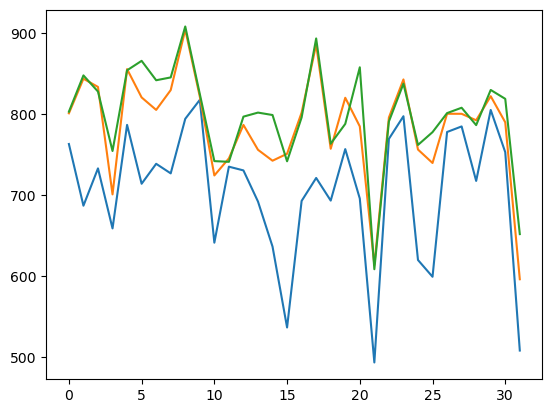

In [28]:
plt.plot(plot_result)

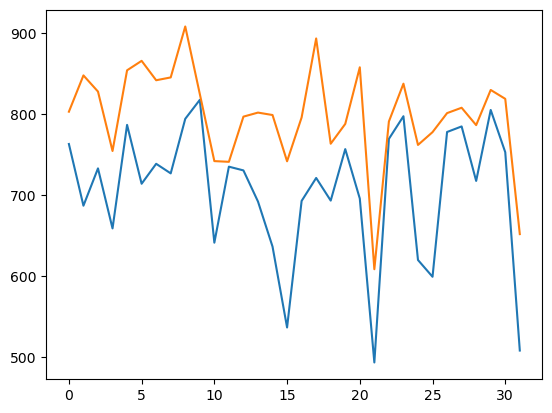

In [5]:
plt.plot(plot_result[['PD','GA']])


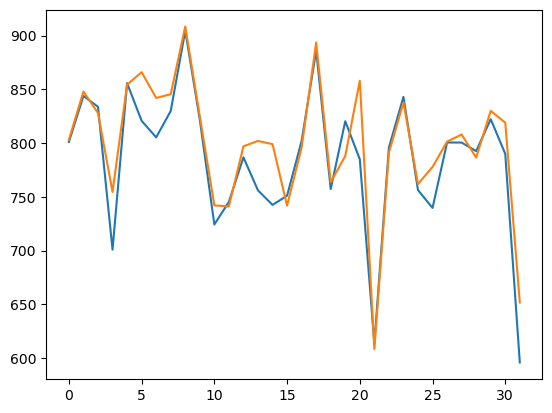

In [6]:
plt.plot(plot_result[['LA','GA']])


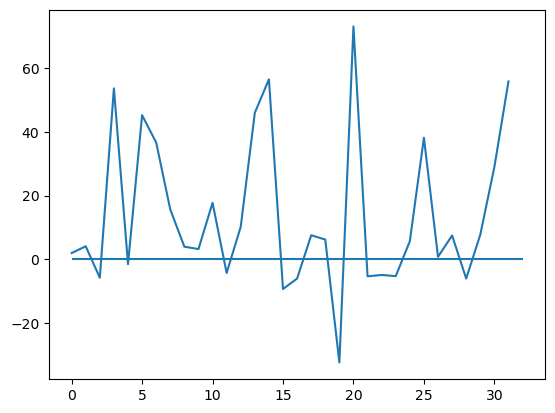

In [26]:
plt.plot(plot_result['GA']-plot_result['LA'])
plt.hlines(0,0,32)
